In this notebook we use OpeNDAP to extract time series data at a single location of interest, then plot this data. This extraction process can also be done with the AIMS eReefs data extraction tool (https://extraction.ereefs.aims.gov.au/). If you which to perform bigger extractions then we recommend using this tool instead of this process outlined in this example. Note: This script has no error checking and so changing the date ranges or locations might result in out of bounds errors.

In [1]:
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import os
import datetime
import pandas as pd
import numpy as np
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

The first part of the process is to choose the OPeNDAP end point on the AIMS eReefs THREDD server. You can view the products here: http://thredds.ereefs.aims.gov.au/thredds/s3catalogue/aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/catalog.html.
At this stage there is no grouped OPeNDAP service for the entire time series and so this script only works for looking at a single month of data. Hopefully this can be improved in the future.

In [2]:
# Connect to the OpeNDAP endpoint for the specified month.  
month = 3
year = 2020
netCDF_datestr = str(year)+'-'+format(month, '02')
netCDF_datestr

'2020-03'

In [3]:
# OPeNDAP URL to file "EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-YYYY-MM.nc". Hydrodynamic 4km model, daily data for the month specified
inputFile = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-"+netCDF_datestr+".nc"

nc_data = Dataset(inputFile, 'r')
print(nc_data.title)

# To find a list of the variables uncomment the next line: 
nc_data.variables

eReefs AIMS-CSIRO GBR4 Hydrodynamic v2 daily aggregation


{'mean_cur': <class 'netCDF4._netCDF4.Variable'>
 float32 mean_cur(time, k, latitude, longitude)
     coordinates: time zc latitude longitude
     substanceOrTaxon_id: http://environment.data.gov.au/def/feature/ocean_current
     units: ms-1
     medium_id: http://environment.data.gov.au/def/feature/ocean
     unit_id: http://qudt.org/vocab/unit#MeterPerSecond
     short_name: mean_cur
     aggregation: mean_speed
     standard_name: mean_current_speed
     long_name: mean_current_speed
     _ChunkSizes: [  1   1 133 491]
 unlimited dimensions: time
 current shape = (31, 17, 723, 491)
 filling off,
 'salt': <class 'netCDF4._netCDF4.Variable'>
 float32 salt(time, k, latitude, longitude)
     coordinates: time zc latitude longitude
     substanceOrTaxon_id: http://sweet.jpl.nasa.gov/2.2/matrWater.owl#SaltWater
     scaledQuantityKind_id: http://environment.data.gov.au/def/property/practical_salinity
     short_name: salt
     aggregation: Daily
     units: PSU
     medium_id: http://envi

Work out the bounds of the gridded data. We can then used this to find out which grid cell best matches our location of interest. Note: This only works because the AIMS eReefs aggregate datasets are regridded onto a regularly spaced grid. The original raw model data is on a curvilinear grid and this approach would not work for that data.

In [4]:
lons = nc_data.variables['longitude'][:]
max_lon = max(lons)
min_lon = min(lons) 
lats = nc_data.variables['latitude'][:]
max_lat = max(lats)
min_lat = min(lats)
grid_lon = lons.size
grid_lat = lats.size
print("Grid bounds, Lon: "+str(min_lon)+" - "+str(max_lon)+" Lat:"+str(min_lat)+" - "+str(max_lat))
print("Grid size is: "+str(grid_lon)+" x "+str(grid_lat))

Grid bounds, Lon: 142.168788 - 156.868788 Lat:-28.696022 - -7.036022
Grid size is: 491 x 723


Find the closest index to the location of interest.

In [5]:
# Davies reef
lat = -18.82
lon = 147.64
selectedLatIndex = round((lat-min_lat)/(max_lat-min_lat)*grid_lat)
selectedLonIndex = round((lon-min_lon)/(max_lon-min_lon)*grid_lon)
print("Grid position of location: "+str(selectedLatIndex)+", "+str(selectedLonIndex))

Grid position of location: 330, 183


Extract the values over time at this location. Note that because we are access the underlying data here this results in an OpeNDAP call to get the data from the remote server. As a result this call can take a while (~10 sec).

In [6]:
selectedDepthIndex = 15 # -1.5m
selectedDepthIndex2 = 10 # -17.75m

# Time, Depth, Lat, Lon
dailyTemp1 = nc_data.variables['temp'][:,[selectedDepthIndex,selectedDepthIndex2], selectedLatIndex, selectedLonIndex]
print(dailyTemp1[0:5])

[[29.586527 27.764503]
 [29.513176 27.867159]
 [29.505758 28.179167]
 [29.782936 28.216429]
 [30.008278 28.062304]]


Let's get the wind for the same location. The wind variable doesn't have any depth dimension and so our indexing into the data is different. The wind is a vector measurement, with an x and y component. 

In [7]:
wspeed_v = nc_data.variables['wspeed_v'][:, selectedLatIndex, selectedLonIndex]
wspeed_u = nc_data.variables['wspeed_v'][:, selectedLatIndex, selectedLonIndex]

To get the wind speed we need to calculate the magnitude of this vector.

In [8]:
wspeed = np.sqrt(wspeed_v**2 + wspeed_u**2)

Get the time series. Note that the time values are stored as the number of days since 1990-01-01 00:00:00 +10. 

In [9]:
times = nc_data.variables['time'][:]
print(times[0:5])

[11017. 11018. 11019. 11020. 11021.]


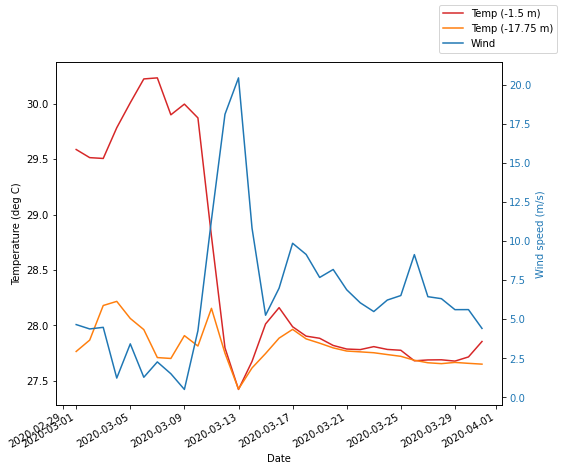

In [10]:
# Convert the days since the 1990 origin into Pandas dates for plotting
t = pd.to_datetime(times,unit='D',origin=pd.Timestamp('1990-01-01'))

fig, ax1 = plt.subplots()
fig.set_size_inches(8, 7)


ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature (deg C)')
ax1.plot(t, dailyTemp1[:,0], color='tab:red', label='Temp (-1.5 m)')
ax1.plot(t, dailyTemp1[:,1], color='tab:orange', label='Temp (-17.75 m)')
#ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Wind speed (m/s)', color=color)  # we already handled the x-label with ax1
ax2.plot(t, wspeed, color=color, label='Wind')
ax2.tick_params(axis='y', labelcolor=color)

fig.legend()
# Set the axes formating to show the dates on an angle on the current figure (gcf)
plt.gcf().autofmt_xdate()

#fig.tight_layout()  # otherwise the right y-label is slightly clipped

From this graph we can see that the surface water at Davies Reef was very warm during March 2020. There was a strong stratification of the temperature profile with cool water at -18 m. Around the 10th March the wind picked up for a few days, mixing the water, cooling the surface down rapidly.